# Label propagation

Goal: determine the number of non-diagnosed / non-tested individuals in the phase 2 population. To extend the knowledge on this unlabelled set from the small labelled subset, we will establish the followin setting:

1. Baseline model > just run the validated transfer-learning-model (validated on phase 2 labelled data) on the unlabelled data
2. Classic approach on label propagation [2]
3. A dual self-supervised learning (SSL) and Semi-supervised learning (Semi-SL) [1] will be implemented.



[1]: Yoon, J., Zhang, Y., Jordon, J., & van der Schaar, M. (2020). Vime: Extending the success of self-and semi-supervised learning to tabular domain. Advances in Neural Information Processing Systems, 33, 11033-11043.
[2]: ZhuЃ, X., & GhahramaniЃн, Z. (2002). Learning from labeled and unlabeled data with label propagation. ProQuest Number: INFORMATION TO ALL USERS.

## Load libraries and data

In [3]:
import os
import numpy as np
import pandas as pd
import importlib
import joblib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import BallTree
from scipy.sparse import csr_matrix
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from joblib import Parallel, delayed
from joblib import dump, load
from sklearn.tree import DecisionTreeClassifier



# import from custom package
from auxFuns.EDA import *
from auxFuns.modelling import *
from auxFuns.class_overlap import *
from auxFuns.transfer_learning import *

In [4]:
import auxFuns.EDA 
importlib.reload(auxFuns.EDA)

import auxFuns.modelling
importlib.reload(auxFuns.modelling)

import auxFuns.class_overlap
importlib.reload(auxFuns.class_overlap)

import auxFuns.transfer_learning
importlib.reload(auxFuns.transfer_learning)

<module 'auxFuns.transfer_learning' from 'c:\\Users\\angel\\Documents\\VSCode\\rsv_modelling_transfer_learning\\auxFuns\\transfer_learning.py'>

In [5]:
# Load of the data and filter in the needed features

raw_datasets_path = os.getcwd() + '/datasets/raw'
processed_datasets_path = os.getcwd() + '/datasets/processed'

# Phase 1 data
rsv_predictors_df_v2 = pd.read_csv(processed_datasets_path + '/rsv_predictors_phase1_daysDedup_seasons_prevTest_v2.csv',low_memory=False)
rsv_predictors_phase1_df = make_it_categorical_v2(rsv_predictors_df_v2)

# Phase 2 data
rsv_phase2_df = pd.read_csv(processed_datasets_path + '/rsv_phase2_all_features.csv',low_memory=False)
rsv_phase2_df = make_it_categorical_v2(rsv_phase2_df, is_phase1 = False)

# Small subset of labelled data of phase 2:
labels_phase2_df = pd.read_csv(raw_datasets_path + '/rsv_test_phase2.csv',low_memory=False)
labels_phase2_df = labels_phase2_df.rename(columns = {'RSV_test_date':'index_date'})

# Compatibility issue detected: merging labelled and unlabelled data is challening due to incompatible date columns
rsv_phase2_df.index_date = pd.to_datetime(rsv_phase2_df.index_date)
labels_phase2_df.index_date = pd.to_datetime(labels_phase2_df.index_date)

rsv_phase2_labelled_df = labels_phase2_df.merge(rsv_phase2_df, how='left', on=['patient_id', 'index_date'])
# rsv_phase2_labelled_df = labels_phase2_df.merge(rsv_phase2_df, how='left', on=['patient_id'])
rsv_phase2_labelled_df = rsv_phase2_labelled_df.dropna()

rsv_predictors_phase1_df.shape, rsv_phase2_df.shape, rsv_phase2_labelled_df.shape

((86058, 64), (291938, 63), (2867, 64))

In [6]:
selected_features = ['sex', 'marital_status', 'race','patient_regional_location', 'age_group',
                     'Acute_upper_respiratory_infection','Influenza','Pneumonia','Bronchitis','Symptoms_and_signs__digestive_system_and_abdomen','General_symptoms_and_signs','any_symptom',
                     'COPD','AIDS','Asthma_chronic','CCI',
                     'sine','cosine','calendar_year', 
                     'healthcare_seeking', 'influenza_vaccine',
                     'n_symptoms','prev_positive_rsv','previous_test_daydiff','n_immunodeficiencies', 
                     'tumor_indicator','tumor_last_year',
                     'season',
                     'n_tests_that_day']
selected_features_v1 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'season','multiple_tests']
selected_features_v2 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'key_comorbidities','Pneumonia',
                     'season','month_of_the_test','multiple_tests',
                     'BPA','BPAI']
selected_features_v3 = selected_features_v2 + ['race', 'age_group','marital_status','sex',
                                                    'patient_regional_location','calendar_year']

rsv_test_related_features = ['n_tests_that_day', 'previous_test_daydiff', 'multiple_tests']
selected_features_v4 = selected_features_v2.copy()
[selected_features_v4.remove(feature) for feature in rsv_test_related_features]

selected_features_v4_aux = selected_features_v4.copy()
selected_features_v1.append('RSV_test_result')
selected_features_v2.append('RSV_test_result')
selected_features_v3.append('RSV_test_result')
selected_features_v4.append('RSV_test_result')

In [7]:
df_modelling_phase1 = rsv_predictors_phase1_df[selected_features_v4]
df_modelling_phase2 = rsv_phase2_labelled_df[selected_features_v4]
df_modelling_all_phase2 = rsv_phase2_df[selected_features_v4_aux]

# differentiate between labelled and non-labelled data in phase 2
labelled_data_phase2_mask = rsv_phase2_labelled_df.index
labelled_mask = rsv_phase2_df.index.isin(labelled_data_phase2_mask)
non_labelled_mask = ~rsv_phase2_df.index.isin(labelled_data_phase2_mask)

df_phase2_labelled = df_modelling_phase2.copy()
df_phase2_unlabelled = df_modelling_all_phase2.loc[non_labelled_mask,:]

df_modelling_phase1.shape, df_phase2_labelled.shape, df_phase2_unlabelled.shape

((86058, 18), (2867, 18), (289071, 17))

## 0. Baseline model: running the previously developed model on the unlabelled data

In [8]:
X_phase2_labelled = df_phase2_labelled.drop(['RSV_test_result'], axis = 1)
y_phase2_labelled = df_phase2_labelled.RSV_test_result
X_phase2_unlabelled = df_phase2_unlabelled.copy()

X_phase2_labelled_train, X_phase2_labelled_valid, y_phase2_labelled_train, y_phase2_labelled_valid = train_test_split(X_phase2_labelled, y_phase2_labelled, test_size=0.99, random_state=42, stratify = y_phase2_labelled)

X_phase2_all = pd.concat([X_phase2_labelled, X_phase2_unlabelled], axis = 0)


# Bring the baseline models developed previously
phase2_models_path = os.getcwd() + '/models/models_phase2'

model_nonOverlapping_baselineLabelProp = joblib.load(phase2_models_path + '/nonOverlapping_approach4_DomainAdaptation_20230910.joblib')
model_Overlapping_baselineLabelProp = joblib.load(phase2_models_path + '/Overlapping__approach4_DomainAdaptation_20230910.joblib')

In [9]:
clf_nonOverlapping = model_nonOverlapping_baselineLabelProp
clf_Overlapping = model_Overlapping_baselineLabelProp

probs_nonOverlapping = clf_nonOverlapping.predict_proba(pd.get_dummies(X_phase2_labelled_valid))[:,1]
probs_Overlapping = clf_Overlapping.predict_proba(pd.get_dummies(X_phase2_labelled_valid))[:,1]
# factor_Overlapping and factor_nonOverlapping are built based on the proportion of overlapping points discovered in p1_05_domain_adaptation.ipynb
factor_Overlapping= 4720 / (4720 + 81338)
factor_nonOverlapping = 81338 / (4720 + 81338)
probs_0 = (factor_nonOverlapping*probs_nonOverlapping + (factor_Overlapping)*probs_Overlapping)
optimal_thr_0= find_optimal_moving_threshold_from_probas(probs_0, y_test = y_phase2_labelled_valid, verbose = False)

y_pred = ['Positive' if (prob>optimal_thr_0) else 'Negative' for prob in probs_0]

# various elements to store:
initial_f1 = f1_score(y_phase2_labelled_valid, y_pred, pos_label = 'Positive')  

In [10]:
# Predict the number of labelled points here:
probs_nonOverlapping_all = clf_nonOverlapping.predict_proba(pd.get_dummies(X_phase2_all))[:,1]
probs_Overlapping_all = clf_Overlapping.predict_proba(pd.get_dummies(X_phase2_all))[:,1]

probs_all = (factor_nonOverlapping*probs_nonOverlapping_all + (factor_Overlapping)*probs_Overlapping_all)

y_pred_baseline = ['Positive' if (prob>optimal_thr_0) else 'Negative' for prob in probs_all]

pd.Series(y_pred_baseline).value_counts()

Negative    262861
Positive     29077
dtype: int64

## 1. Autolabelling

### Bootstrap iterative approach

In [11]:
X_phase2_labelled = df_phase2_labelled.drop(['RSV_test_result'], axis = 1)
y_phase2_labelled = df_phase2_labelled.RSV_test_result
X_phase2_unlabelled = df_phase2_unlabelled.copy()

X_phase2_labelled_train, X_phase2_labelled_valid, y_phase2_labelled_train, y_phase2_labelled_valid = train_test_split(X_phase2_labelled, y_phase2_labelled, test_size=0.1, random_state=42, stratify = y_phase2_labelled)

X_phase2_all = pd.concat([X_phase2_labelled, X_phase2_unlabelled], axis = 0)

In [12]:
# Bring the baseline models developed previously
phase2_models_path = os.getcwd() + '/models/models_phase2'

model_nonOverlapping_baselineLabelProp = joblib.load(phase2_models_path + '/nonOverlapping_approach4_DomainAdaptation_20230910.joblib')
model_Overlapping_baselineLabelProp = joblib.load(phase2_models_path + '/Overlapping__approach4_DomainAdaptation_20230910.joblib')

In [13]:
def get_high_confidence_samples(df, predicted_probs, threshold_up = 0.9, threshold_down = 0.10):
    """
    Identify and return samples that are classified with high confidence based on the specified thresholds.
    Part of the autolabelling algorithm of p2_06_label_propagation.ipynb
    
    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the samples.
    predicted_probs : np.ndarray
        The array containing predicted probabilities for each sample.
    threshold_up : float, optional
        The upper threshold for considering a sample as 'Positive'. Default is 0.9.
    threshold_down : float, optional
        The lower threshold for considering a sample as 'Negative'. Default is 0.1.

    Returns
    -------
    high_conf_samples : pd.DataFrame
        DataFrame containing the samples that are classified with high confidence.
    high_conf_labels : pd.Series
        Series containing the labels ('Positive' or 'Negative') for the high-confidence samples.
    """

    # Identify indices where predicted probabilities exceed the threshold
    high_conf_indices = np.where((predicted_probs < threshold_down) | (predicted_probs > threshold_up))[0]
    
    # Extract these samples and labels
    high_conf_samples = df.iloc[high_conf_indices]
    high_conf_labels = pd.Series(['Positive' if (prob>threshold_up) else 'Negative' for prob in predicted_probs[high_conf_indices]])

    return high_conf_samples, high_conf_labels

In [38]:
def perform_autolabelling_iteration(df_phase2_labelled, df_phase2_unlabelled, model_nonOverlapping_baselineLabelProp, model_Overlapping_baselineLabelProp,
    verbose = False):
    metrics_log = []
    positive_labels_added_per_step = []
    cumulative_positive_labels = []
    negative_labels_added_per_step = []
    cumulative_negative_labels = []

    # Your data preparation code
    X_phase2_labelled = df_phase2_labelled.drop(['RSV_test_result'], axis=1)
    y_phase2_labelled = df_phase2_labelled.RSV_test_result
    X_phase2_unlabelled = df_phase2_unlabelled.copy()

    X_phase2_labelled_train, X_phase2_labelled_valid, y_phase2_labelled_train, y_phase2_labelled_valid = train_test_split(
    X_phase2_labelled, y_phase2_labelled, test_size=0.1, random_state=42, stratify=y_phase2_labelled)

    # Your model loading code
    clf_nonOverlapping = model_nonOverlapping_baselineLabelProp
    clf_Overlapping = model_Overlapping_baselineLabelProp
    
    # Initialize metrics log
    metrics_log = []

    # Baseline model training and evaluation
    clf_nonOverlapping = model_nonOverlapping_baselineLabelProp
    clf_Overlapping = model_Overlapping_baselineLabelProp

    probs_nonOverlapping = clf_nonOverlapping.predict_proba(pd.get_dummies(X_phase2_labelled_valid))[:,1]
    probs_Overlapping = clf_Overlapping.predict_proba(pd.get_dummies(X_phase2_labelled_valid))[:,1]
    probs_0 = (probs_nonOverlapping+probs_Overlapping)/2
    optimal_thr_0= find_optimal_moving_threshold_from_probas(probs_0, y_test = y_phase2_labelled_valid, verbose = False)

    y_pred = ['Positive' if (prob>optimal_thr_0) else 'Negative' for prob in probs_0]

    # various elements to store:
    initial_f1 = f1_score(y_phase2_labelled_valid, y_pred, pos_label = 'Positive')  
    metrics_log.append(initial_f1)
    positive_labels_added_per_step = []
    cumulative_positive_labels = []
    negative_labels_added_per_step = []
    cumulative_negative_labels = []

    max_iterations = 150
    X_labelled_train = pd.get_dummies(X_phase2_labelled_train)
    y_labelled_train = y_phase2_labelled_train.copy()
    unlabelled_dummies = pd.get_dummies(df_phase2_unlabelled)

    threshold_up = 0.90
    threshold_down = 0.20

    # Iterative Loop
    for i in tqdm.tqdm(range(max_iterations)):

        # Model Confidence
        probs_nonOverlapping = clf_nonOverlapping.predict_proba(unlabelled_dummies)[:,1]
        probs_Overlapping = clf_Overlapping.predict_proba(unlabelled_dummies)[:,1]
        predicted_probs = (probs_nonOverlapping+probs_Overlapping)/2

        high_conf_samples, high_conf_labels = get_high_confidence_samples(df = unlabelled_dummies, predicted_probs = predicted_probs,
                                                                        threshold_up = threshold_up, threshold_down = threshold_down)
        high_conf_labels = pd.Series(pd.Categorical(high_conf_labels, categories = ['Positive', 'Negative']))
        # Data Augmentation
        X_labelled_train = pd.concat([X_labelled_train, high_conf_samples], axis = 0)
        y_labelled_train = pd.concat([y_labelled_train, high_conf_labels], axis = 0)
        unlabelled_dummies = unlabelled_dummies.drop(high_conf_samples.index)
        
        # Iterative Refinement
        clf_nonOverlapping = DecisionTreeClassifier()
        clf_nonOverlapping.fit(X_labelled_train, y_labelled_train)
        # clf_Overlapping.fit(X_labelled_train, y_labelled_train)
        
        # Evaluation
        probs_nonOverlapping = clf_nonOverlapping.predict_proba(pd.get_dummies(X_phase2_labelled_valid))[:,1]
        # probs_Overlapping = clf_Overlapping.predict_proba(pd.get_dummies(X_phase2_labelled_valid))[:,1]
        # probs = (probs_nonOverlapping+probs_Overlapping)/2
        probs = probs_nonOverlapping * 3
        optimal_thr_0= find_optimal_moving_threshold_from_probas(probs, y_test = y_phase2_labelled_valid, verbose = False)

        y_pred = ['Positive' if (prob>optimal_thr_0) else 'Negative' for prob in probs]

        iter_metrics = f1_score(y_phase2_labelled_valid, y_pred, pos_label = 'Positive')  
        metrics_log.append(iter_metrics)

        # Print how everything is going
        if verbose: 
            print('\n---------------')
            print(f'Iteration #{i}')
            print(f'F1-score: {iter_metrics}')
            print(f'Labelled points in this point: {len(high_conf_labels)}')
            print(f'Positive and negatives labelled: \n{high_conf_labels.value_counts()}')
            print(f'Remaining unlabelled points: {unlabelled_dummies.shape[0]}')

        # Append the values to store
        positive_labels_added_per_step.append(high_conf_labels.value_counts()['Positive'])
        cumulative_positive_labels.append(y_labelled_train.value_counts()['Positive'])
        negative_labels_added_per_step.append(high_conf_labels.value_counts()['Negative'])
        cumulative_negative_labels.append(y_labelled_train.value_counts()['Negative'])


        if (len(high_conf_labels) == 0) and (0.9*threshold_up >= 1.11*threshold_down):
            threshold_up = threshold_up*0.9
            threshold_down = 1.1*threshold_down
        elif (high_conf_labels.value_counts()['Positive'] == 0) and (0.9*threshold_up > threshold_down):
            threshold_up = threshold_up*0.9
        elif (high_conf_labels.value_counts()['Negative'] == 0) and (threshold_up > 1.1*threshold_down):
            threshold_down = 1.1*threshold_down
        elif (len(high_conf_labels) == 0) and (0.9*threshold_up < 1.11*threshold_down):
            break
        elif (len(high_conf_labels) == 0) and (0.9*threshold_up < 1.11*threshold_down):
            threshold_up = 0.5
            threshold_down = 0.5
        
        # Convergence Check (implement as needed)
        if unlabelled_dummies.shape[0] == 0:  
            break

        if (threshold_up < 0.75) or (threshold_down > 0.25):
            # print('Broke because of threshold limit')
            # print(f'Threshold up: {threshold_up} \nThreshold down: {threshold_down}')
            break


    return y_labelled_train, metrics_log, positive_labels_added_per_step, cumulative_positive_labels, negative_labels_added_per_step, cumulative_negative_labels

    

In [ ]:
B = 100
all_metrics = {
    'y_labelled': [],
    'metrics_log': [],
    'positive_labels_added_per_step': [],
    'cumulative_positive_labels': [],
    'negative_labels_added_per_step': [],
    'cumulative_negative_labels': []
}

for b in tqdm.tqdm(range(B)):
    y_labelled, metrics, pos_step, cumul_pos, neg_step, cumul_neg = perform_autolabelling_iteration(
        df_phase2_labelled, df_phase2_unlabelled,
        model_nonOverlapping_baselineLabelProp, model_Overlapping_baselineLabelProp)
    print(f'Final labels after autolabelling: {y_labelled.value_counts()}')

    all_metrics['y_labelled'].append(y_labelled)
    all_metrics['metrics_log'].append(metrics)
    all_metrics['positive_labels_added_per_step'].append(pos_step)
    all_metrics['cumulative_positive_labels'].append(cumul_pos)
    all_metrics['negative_labels_added_per_step'].append(neg_step)
    all_metrics['cumulative_negative_labels'].append(cumul_neg)

In [336]:
# Now analyze the boostrapped resuls
final_positive_counts = []
final_negative_counts = []
final_unlabelled_counts = []

total_size_phase2 = (2867 + 289071 - len(y_phase2_labelled_valid))

for y_labelled_series in all_metrics['y_labelled']:
    counts = y_labelled_series.value_counts()
    final_positive_counts.append(counts['Positive'])
    final_negative_counts.append(counts['Negative'])
    unlabelled_n = total_size_phase2 - (counts['Positive'] + counts['Negative'])
    final_unlabelled_counts.append(unlabelled_n)


bootstrapped_estimator_positive = np.mean(final_positive_counts)
variance_estimator_positive = np.var(final_positive_counts)

bootstrapped_estimator_negative = np.mean(final_negative_counts)
variance_estimator_negative = np.var(final_negative_counts)

bootstrapped_estimator_unlabelled = np.mean(final_unlabelled_counts)
variance_estimator_unlabelled = np.var(final_unlabelled_counts)


In [ ]:
df = pd.DataFrame({
    'Positive Counts': final_positive_counts,
    'Negative Counts': final_negative_counts,
    'Unlabelled Counts': final_unlabelled_counts
})
light_red = (0.9, 0.4, 0.4) 
light_grey = (0.7, 0.7, 0.7) 
light_blue = (0.4, 0.4, 0.9) 
custom_palette = {'Positive Counts': light_red,
                  'Negative Counts': light_blue,
                  'Unlabelled Counts': light_grey}

fig, axs = plt.subplots(1, 2, figsize=(12, 3.5))

# Scatter-Line plot with variance delimiter
for col, col_color in custom_palette.items():
    sns.lineplot(data=df[col], ax=axs[0], label=f'{col} Estimates', color=col_color)
    axs[0].fill_between(df.index,
                        df[col] - np.sqrt(np.var(df[col])),
                        df[col] + np.sqrt(np.var(df[col])),
                        color=col_color,
                        alpha=0.2)
axs[0].set_yscale("log")
axs[0].set_ylabel("")
axs[0].set_xlabel("# of bootstrap iteration")
axs[0].set_yticks([12000, 16000, 66000, 112000,165000, 215000])
axs[0].get_yaxis().set_major_formatter(plt.ScalarFormatter())  # Show the tick labels as plain numbers instead of scientific notation
axs[0].set_yticklabels([12000, 16000, 66000, 112000, 165000, 215000])  # Set the labels explicitly
axs[0].set_title('Autolabelling: predicted counts at every bootstrap iteration')

# Combined plot: Boxplot with swarmplot overlay
sns.boxplot(data=df, ax=axs[1], palette=custom_palette)
sns.swarmplot(data=df, size=8, alpha=0.5, color=".25", ax=axs[1])
# axs[1].set_yscale("log")
axs[1].set_title('Visualization of the variance of the predicted counts')



plt.tight_layout()
plt.show()


## 2. Label propagation classic algorithm

Steps in label propagation build-up:
- 1. Data preparation and graph construction
- 2. Initialize transition matrix
- 3. Initialize label matrix
- 4. Label prpagation
- 5. Parameter learning
- 6. Evaluation metrics

In [6]:
# 2.1. Data preparation and graph construction
X_phase2_labelled = df_phase2_labelled.drop(['RSV_test_result'], axis = 1)
y_phase2_labelled = df_phase2_labelled.RSV_test_result
X_phase2_unlabelled = df_phase2_unlabelled.copy()

X_phase2_all = pd.concat([X_phase2_labelled, X_phase2_unlabelled], axis = 0)

In [10]:
# Construct the graph
# In this case, proven the suitability of the method with this type of data, Ball Trees are sued
n_total_samples = X_phase2_all.shape[0]
n_neighbours = 51 # the number of neighbours is increased so all the instances are better connected
X_phase2_all_dummies = pd.get_dummies(X_phase2_all)

print('Build-up of the tree for X_phase2_all ...')
tree = BallTree(X_phase2_all_dummies)
print(f'Distance matrix for {n_neighbours-1} nearest neighbours ...')
# distances_tree, indices_tree = tree.query(X_phase2_all_dummies, k=n_neighbours)

# Batch computing to try to make the process faster 
all_distances = []
all_indices = []

batch_size = 1000 

for i in tqdm.tqdm(range(0, len(X_phase2_all_dummies), batch_size)):
    batch_distances, batch_indices = tree.query(X_phase2_all_dummies[i:i+batch_size], k=n_neighbours)
    all_distances.append(batch_distances)
    all_indices.append(batch_indices)

distances_tree = np.concatenate(all_distances, axis=0)
indices_tree = np.concatenate(all_indices, axis=0)

## As we want a relevant value for self-transition, i.e. the diagonal entries of the transition matrix, we will not remove the first column of the
## distances and indices matries, as these will later impact the self transition value of the matrix
distances_to_other_points = distances[:,-1:]
indices_neighbours = indices[:,-1:]

Build-up of the tree for X_phase2_all ...
Distance matrix for 50 nearest neighbours ...


100%|██████████| 292/292 [1:15:12<00:00, 15.46s/it]


In [ ]:
# 2.2. Initialize the transition matrix
## Hyperparameters here: sigma
## Transition matrix is taken as a sparse matrix, as distance is taken exclusivelly to the {n_neighbours} of closest neighbours
transition_matrix = csr_matrix((n_total_samples, n_total_samples), dtype=np.float32)

sigma = 20.5 # this value is selected after debugging of the model
sigma_list =[]
transition_matrix = transition_matrix.tolil() # brought to this format to ensure optimal computation

# use of Parallel to optimize computation
k = 20
amplifying_factor = 30
def process_sample(i):
    k_nearest_distances = distances_tree[i][:k]
    sigma_i = (np.mean(k_nearest_distances))*amplifying_factor # dinamically computing sigma 
    sigma_list.append(sigma_i)
    weights = np.exp(-distances_tree[i]**2 / (2 * sigma_i ** 2))
    weights /= np.sum(weights)
    weights = weights**2 
    return i, indices_tree[i], weights

with tqdm.tqdm(total=n_total_samples) as pbar:
    def update(*args):
        pbar.update()

    result = Parallel(n_jobs=-1, backend='threading', verbose=0, pre_dispatch='all')(
        delayed(process_sample)(i) for i in range(n_total_samples)
    )

    for i, ind, weights in result:
        transition_matrix[i, ind] = weights
        update()

transition_matrix = transition_matrix.tocsr()

# Replace NaNs with zeros
def replace_nans_with_zeros(sparse_matrix):
    nan_indices = np.isnan(sparse_matrix.data)
    sparse_matrix.data[nan_indices] = 0.0
replace_nans_with_zeros(transition_matrix)


In [406]:
# 2.3. Initialize Label Matrix
label_to_int = {'Negative': 0, 'Positive': 1}

n_classes = len(['Negative', 'Positive'])
label_matrix = np.zeros((n_total_samples, n_classes))

for idx, label in tqdm.tqdm(enumerate(y_phase2_labelled), total=len(y_phase2_labelled)):
    label_matrix[idx, label_to_int[label]] = 1

## The first {len(y_phase2_labelled)} correspond to the labelled subset
## The last {label_matrix[len(y_phase2_labelled):,:]} (all 0s at these point) correspond to the unlabelled set

100%|██████████| 2867/2867 [00:00<00:00, 409266.54it/s]


In [40]:

def perform_label_propagation(transition_matrix, label_matrix, alpha=1.0, beta=1.0, n_iterations=1000, convergence_threshold=1e-10, test_size=0.1):
    n_labelled = len(label_matrix)
    n_classes = label_matrix.shape[1]
    n_labelled_validation = round(2867 * test_size)
    n_labelled_training = n_labelled - n_labelled_validation

    Y_current_training = label_matrix[n_labelled_validation:]
    Y_current_validation = np.zeros((n_labelled_validation, n_classes))
    Y_current = np.vstack([Y_current_validation, Y_current_training])
    changes = []
    count_positive_over_time = []
    count_negative_over_time = []
    

    for iteration in range(n_iterations):
        # Perform label propagation only on unlabeled data:
        Y_next = transition_matrix.dot(Y_current)
        Y_next[:, 0] *= beta  # Assuming 'Negative' is at index 0
        Y_next[:, 1] *= alpha  # Assuming 'Positive' is at index 1
        
        # Renormalize so that rows sum to 1
        row_sums = np.sum(Y_next, axis=1, keepdims=True)
        zero_rows = (np.isclose(row_sums, 0)).flatten()
        Y_next[~zero_rows] = Y_next[~zero_rows] / row_sums[~zero_rows]

        ## the labelled subset remains as it was, but the validation set does change
        Y_next[n_labelled_validation:n_labelled] = Y_current[n_labelled_validation:n_labelled] 

        # track the differences in labelling through time
        labelled_Y_next = Y_current[~(np.array(([x.sum() for x in (Y_current == [0,0])])) == 2)]

        count_positive_over_time.append((np.round(labelled_Y_next[:,1]) == 1).sum())
        count_negative_over_time.append((np.round(labelled_Y_next[:,0]) == 1).sum())

        n_unlabelled_validation = (np.array([x.sum() for x in (Y_next[:n_labelled_validation,:] == [0,0])]) == 2).sum()
        n_unlabelled_total = (np.array([x.sum() for x in (Y_next == [0,0])]) == 2).sum()
        change_between_next_and_current = np.linalg.norm(Y_next - Y_current, ord='fro')
        changes.append(change_between_next_and_current)

        if np.cumsum(count_positive_over_time[-1]) > 10000:
            
            print('Break 1')
            print(f'Number of negative labelled points: {(np.round(Y_current[:,0]) == 1).sum()}')
            print(f'Number of positive labelled points: {(np.round(Y_current[:,1]) == 1).sum()}')
            print(f'FInal norm change: {change_between_next_and_current}')
            break
        if change_between_next_and_current < convergence_threshold:
            print('Break 2')    
            print(f'Number of negative labelled points: {(np.round(Y_current[:,0]) == 1).sum()}')
            print(f'Number of positive labelled points: {(np.round(Y_current[:,1]) == 1).sum()}')
            print(f'FInal norm change: {change_between_next_and_current}')
            break

        Y_current = Y_next
        
    

    metrics_log = changes  # This could be extended to include other metrics
    positive_labels_added_per_step = count_positive_over_time
    cumulative_positive_labels = np.cumsum(count_positive_over_time)
    negative_labels_added_per_step = count_negative_over_time
    cumulative_negative_labels = np.cumsum(count_negative_over_time)
    
    return Y_current, metrics_log, positive_labels_added_per_step, cumulative_positive_labels, negative_labels_added_per_step, cumulative_negative_labels, changes


In [ ]:
# Initialize your dictionaries for label propagation
all_metrics_labelProp = {
    'y_labelled_labelProp': [],
    'metrics_log_labelProp': [],
    'positive_labels_added_per_step_labelProp': [],
    'cumulative_positive_labels_labelProp': [],
    'negative_labels_added_per_step_labelProp': [],
    'cumulative_negative_labels_labelProp': [],
    'changes_labelProp': []
}

B = 10  # Number of bootstrap iterations
# After running this analysis, it has been observed this process is deterministic, so bootstrapping is not needed

for b in tqdm.tqdm(range(B)):
    # Perform label propagation
    y_labelled_labelProp, metrics_log_labelProp, pos_step_labelProp, cumul_pos_labelProp, neg_step_labelProp, cumul_neg_labelProp, changes_labelProp = perform_label_propagation(
        transition_matrix, label_matrix)
    
    # Append the metrics to your dictionaries
    all_metrics_labelProp['y_labelled_labelProp'].append(y_labelled_labelProp)
    all_metrics_labelProp['metrics_log_labelProp'].append(metrics_log_labelProp)
    all_metrics_labelProp['positive_labels_added_per_step_labelProp'].append(pos_step_labelProp)
    all_metrics_labelProp['cumulative_positive_labels_labelProp'].append(cumul_pos_labelProp)
    all_metrics_labelProp['negative_labels_added_per_step_labelProp'].append(neg_step_labelProp)
    all_metrics_labelProp['cumulative_negative_labels_labelProp'].append(cumul_neg_labelProp)
    all_metrics_labelProp['changes_labelProp'].append(changes_labelProp)

In [ ]:
# Initialize lists to store counts for label propagation
final_positive_counts_labelProp = []
final_negative_counts_labelProp = []
final_unlabelled_counts_labelProp = []

total_size_phase2 = (2867 + 289071 - len(y_phase2_labelled_valid))

# Analyze the bootstrapped results for label propagation
for y_labelled_series in all_metrics_labelProp['y_labelled_labelProp']:
    counts = y_labelled_series.value_counts()
    final_positive_counts_labelProp.append(counts.get('Positive', 0))  # If 'Positive' doesn't exist, append 0
    final_negative_counts_labelProp.append(counts.get('Negative', 0))  # If 'Negative' doesn't exist, append 0
    unlabelled_n = total_size_phase2 - (counts.get('Positive', 0) + counts.get('Negative', 0))
    final_unlabelled_counts_labelProp.append(unlabelled_n)

# Compute bootstrapped estimators and variances for label propagation
bootstrapped_estimator_positive_labelProp = np.mean(final_positive_counts_labelProp)
variance_estimator_positive_labelProp = np.var(final_positive_counts_labelProp)

bootstrapped_estimator_negative_labelProp = np.mean(final_negative_counts_labelProp)
variance_estimator_negative_labelProp = np.var(final_negative_counts_labelProp)

bootstrapped_estimator_unlabelled_labelProp = np.mean(final_unlabelled_counts_labelProp)
variance_estimator_unlabelled_labelProp = np.var(final_unlabelled_counts_labelProp)


Visualization of the label propagation process

In [ ]:
X_phase2_all_dummies = pd.get_dummies(X_phase2_all)

X_phase2_all_dummies.reset_index(drop=True, inplace=True)

# Create a new graph
G = nx.Graph()

# This is the node of interest
node_idx = 140 

# Query its nearest neighbors
distances, indices_graph = tree.query([X_phase2_all_dummies.iloc[node_idx,:]], k=20)  # get k-nearest neighbors
indices_graph = indices_graph[0]  # Flatten the array
selected_nodes = indices_graph

G.add_nodes_from(selected_nodes)

# Populate with colors based on label status
node_colors = []
for i in selected_nodes:
    if i < n_labelled:
        node_colors.append('orange')  
    else:
        node_colors.append('white')  

# Add edges to the graph
for i in indices_graph:
    for j in indices_graph:
        if i != j:
            # Use Gaussian similarity as the weight for the edges
            weight = np.exp(-np.linalg.norm(X_phase2_all_dummies.iloc[i,:] - X_phase2_all_dummies.iloc[j,:])**2 / (2 * sigma ** 2))
            G.add_edge(i, j, weight=weight)

pos = nx.spring_layout(G, weight='weight', seed=42)

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=10)
green_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Labelled', markeredgewidth=0.2, markeredgecolor='black')
red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='white', markeredgecolor='black', markeredgewidth=0.2, markersize=10, label='Unlabelled')
plt.legend(handles=[green_patch, red_patch])
plt.show()


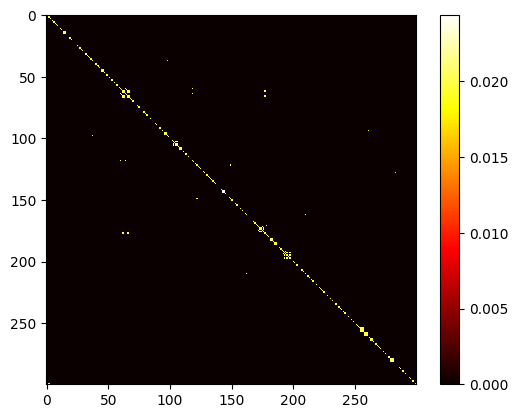

In [117]:
plt.imshow((transition_matrix[170:470, 170:470]).toarray(), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()


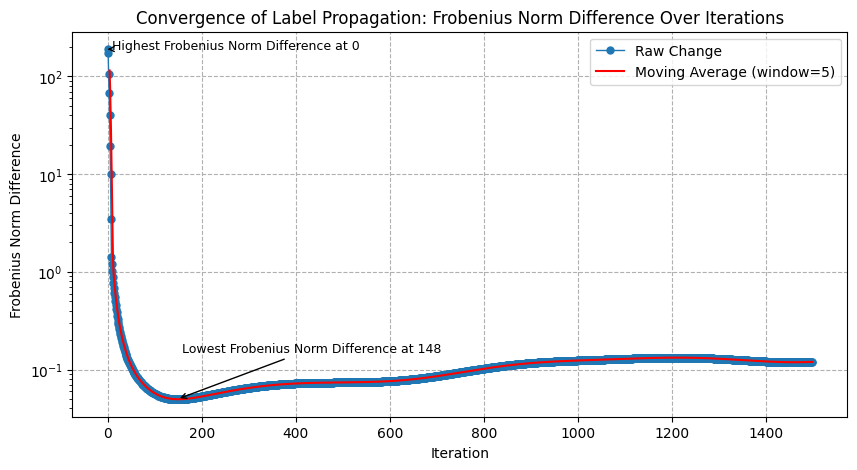

In [118]:
# Mock changes for demonstration. Replace with your actual 'changes' list.
plt.figure(figsize=(10, 5))

# Main plot with markers
plt.plot(changes, marker='o', linestyle='-', linewidth=1, markersize=5, label='Raw Change')

# Add grid
plt.grid(True, linestyle='--')

# Add titles and labels
plt.title('Convergence of Label Propagation: Frobenius Norm Difference Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Frobenius Norm Difference')
plt.gca().set_yscale("log")


# Highlight specific points (like lowest or highest change)
min_change_idx = np.argmin(changes)
max_change_idx = np.argmax(changes)
plt.annotate(f'Lowest Frobenius Norm Difference at {min_change_idx}', xy=(min_change_idx, changes[min_change_idx]), xytext=(min_change_idx+10, changes[min_change_idx]+0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=9)
plt.annotate(f'Highest Frobenius Norm Difference at {max_change_idx}', xy=(max_change_idx, changes[max_change_idx]), xytext=(max_change_idx+10, changes[max_change_idx]+0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=9)

# Optional: Add moving average line
window_size = 5
rolling_mean = np.convolve(changes, np.ones(window_size)/window_size, mode='valid')
plt.plot(np.arange(window_size-1, len(changes)), rolling_mean, 'r', label=f'Moving Average (window={window_size})')

# Add legend
plt.legend()

plt.show()


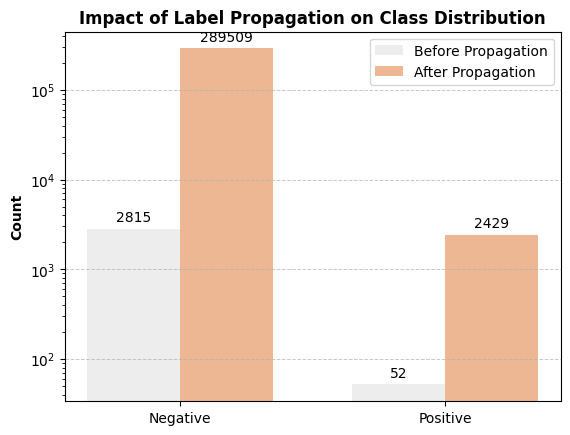

In [124]:
# Dummy data for illustration
labels_before = [y_phase2_labelled.value_counts()['Negative'], y_phase2_labelled.value_counts()['Positive']]
prediction_ofPropagation = pd.Series(['Positive' if label_numeric == 1 else 'Negative' for label_numeric in np.round(Y_next[:,1])])

labels_after = [prediction_ofPropagation.value_counts()['Negative'], prediction_ofPropagation.value_counts()['Positive']]  

# Prepare the plot
x = np.arange(len(labels_before))
width = 0.35

# Create the bar plot
fig, ax = plt.subplots()

light_gray = (0.9, 0.9, 0.9)
rects1 = ax.bar(x - width/2, labels_before, width, alpha=0.7, label='Before Propagation', color=light_gray)
light_orange = (0.9, 0.6, 0.4)
rects2 = ax.bar(x + width/2, labels_after, width, alpha=0.7, label='After Propagation', color=light_orange)

# Add annotations, grid, and labels
ax.set_xticks(x)
ax.set_xticklabels(['Negative', 'Positive'])
ax.set_ylabel('Count', fontweight='bold')
ax.set_title('Impact of Label Propagation on Class Distribution', fontweight='bold')
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
ax.legend()
ax.set_yscale("log")


# Annotate the bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()


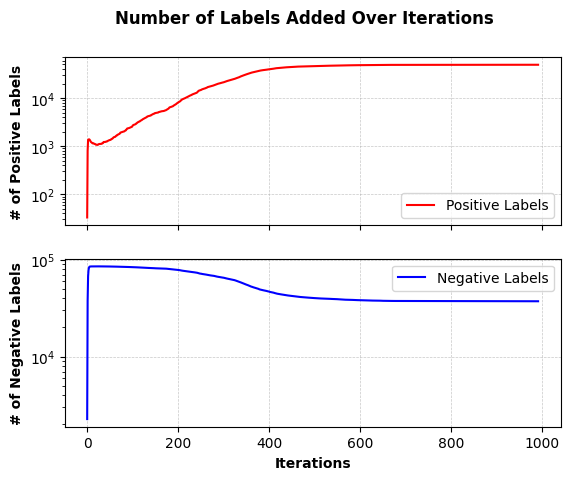

In [111]:
iterations = np.arange(0, iteration+1)

fig, axs = plt.subplots(2, 1, sharex=True)

# Plot for Positive Labels
axs[0].plot(iterations, count_positive_over_time, label='Positive Labels', color='red')
axs[0].set_ylabel('# of Positive Labels', fontweight='bold')
axs[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
axs[0].legend()
axs[0].set_yscale("log")


# Plot for Negative Labels
axs[1].plot(iterations, count_negative_over_time, label='Negative Labels', color='blue')
axs[1].set_xlabel('Iterations', fontweight='bold')
axs[1].set_ylabel('# of Negative Labels', fontweight='bold')
axs[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
axs[1].legend()
axs[1].set_yscale("log")

# Add a title for the whole figure
fig.suptitle('Number of Labels Added Over Iterations', fontweight='bold')

plt.show()
